In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

Create model

In [2]:
# Define the model

def create_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First layer
    conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer=tf.keras.regularizers.l2(0.001) ,padding='valid')(inputs)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv1)
    relu1 = tf.keras.layers.ReLU()(batchnorm1)
    maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(relu1)
    
    # Second layer
    conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer=tf.keras.regularizers.l2(0.001) ,padding='valid')(maxpool1)
    batchnorm2 = tf.keras.layers.BatchNormalization()(conv2)
    relu2 = tf.keras.layers.ReLU()(batchnorm2)
    maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(relu2)
    
    # Third layer
    conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),kernel_regularizer=tf.keras.regularizers.l2(0.001), padding='valid')(maxpool2)
    batchnorm3 = tf.keras.layers.BatchNormalization()(conv3)
    relu3 = tf.keras.layers.ReLU()(batchnorm3)
    avgpool = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(relu3)
    
    # Flatten the output of the last convolutional layer
    flatten = tf.keras.layers.Flatten()(avgpool)
    
    # Fully connected layers
    fc1 = tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(flatten)
    fc2 = tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(fc1)

    # Output layer (binary classification)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(fc2)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

# Example usage
input_shape = (160, 160, 1)  

model = create_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 158, 158, 16)      64        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 158, 158, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 32)        4640  

Loading images

In [4]:
folder1_path = '.\persons\person1'
folder2_path = '.\persons\person2'

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename),cv2.COLOR_BGR2GRAY)
        if img is not None:
            images.append(img)
    return images

images_for_person1 = load_images_from_folder(folder1_path)
images_for_person2 = load_images_from_folder(folder2_path)


indices_to_separate = [2,5,10,11,12,13,15,39,40,41,42,44]

#Separating indices for person 1
testing_indices_person1 = indices_to_separate.copy()
testing_images_person1 = [images_for_person1[i] for i in testing_indices_person1]
remaining_indices_person1 = np.setdiff1d(np.arange(len(images_for_person1)), testing_indices_person1)
training_images_person1 = [images_for_person1[i] for i in remaining_indices_person1]

# Separating indices for person 2
testing_indices_person2 = indices_to_separate.copy()
testing_images_person2 = [images_for_person2[i] for i in testing_indices_person2]
remaining_indices_person2 = np.setdiff1d(np.arange(len(images_for_person2)), testing_indices_person2)
training_images_person2 = [images_for_person2[i] for i in remaining_indices_person2]

Data augmentation

In [ ]:
# Function to perform image sharpening
def sharpen_image(image):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

# Function to perform image flipping
def flip_image(image):
    flipped = cv2.flip(image, 1)  # 1 for vertical flipping
    return flipped

# Perform data augmentation for person 1
augmented_training_images_person1 = []
for image in training_images_person1:
    sharpened_image = sharpen_image(image)
    flipped_image = flip_image(image)
    augmented_training_images_person1.append(sharpened_image)
    augmented_training_images_person1.append(flipped_image)

# Perform data augmentation for person 2
augmented_training_images_person2 = []
for image in training_images_person2:
    sharpened_image = sharpen_image(image)
    flipped_image = flip_image(image)
    augmented_training_images_person2.append(sharpened_image)
    augmented_training_images_person2.append(flipped_image)
             

# Convert lists to numpy arrays
augmented_training_images_person1 = np.array(augmented_training_images_person1)
augmented_training_images_person2 = np.array(augmented_training_images_person2)

Prepare data to feeding

In [7]:
#concatenate the 2 training array and labeling crossponding index in y_train
X_train = np.concatenate((augmented_training_images_person1, augmented_training_images_person2))
y_train = np.concatenate((
    np.zeros(len(augmented_training_images_person1)),
    np.ones(len(augmented_training_images_person2))
))

# Shuffle the data
shuffle_indices = np.random.permutation(len(X_train))
X_train_shuffled = X_train[shuffle_indices]
y_train_shuffled = y_train[shuffle_indices]

Compile and train model

Epoch 1/100
9/9 [==============================] - 4s 197ms/step - loss: 1.8068 - accuracy: 0.6095 - val_loss: 2.0944 - val_accuracy: 0.5581
Epoch 2/100
9/9 [==============================] - 1s 164ms/step - loss: 1.0758 - accuracy: 0.8994 - val_loss: 1.0791 - val_accuracy: 0.8140
Epoch 3/100
9/9 [==============================] - 1s 167ms/step - loss: 0.8455 - accuracy: 0.9763 - val_loss: 0.9168 - val_accuracy: 0.9535
Epoch 4/100
9/9 [==============================] - 1s 163ms/step - loss: 0.7420 - accuracy: 0.9882 - val_loss: 0.8802 - val_accuracy: 0.9535
Epoch 5/100
9/9 [==============================] - 1s 165ms/step - loss: 0.7117 - accuracy: 0.9822 - val_loss: 0.7491 - val_accuracy: 1.0000
Epoch 6/100
9/9 [==============================] - 1s 163ms/step - loss: 0.6585 - accuracy: 0.9882 - val_loss: 0.6587 - val_accuracy: 1.0000
Epoch 7/100
9/9 [==============================] - 1s 163ms/step - loss: 0.6372 - accuracy: 0.9941 - val_loss: 0.6427 - val_accuracy: 0.9767
Epoch 8/100
9

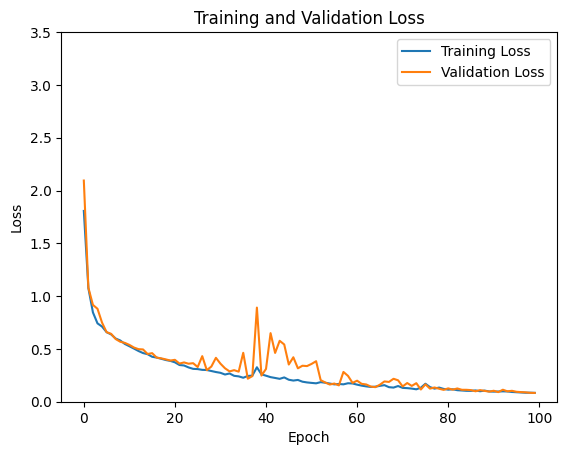

In [8]:
import matplotlib.pyplot as plt

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history=model.fit(X_train_shuffled, y_train_shuffled, epochs=100, batch_size=20, validation_split=0.2)

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3.5)
plt.legend()
plt.show() 

Prepare test data to feeding 

In [9]:
testing_images_person2 = np.array(testing_images_person2)
testing_images_person1 = np.array(testing_images_person1)

X_test=np.concatenate((testing_images_person1, testing_images_person2))
y_test = np.concatenate((np.zeros(len(testing_images_person1)), np.ones(len(testing_images_person2))))

shuffle_indices2 = np.random.permutation(len(X_test))
X_test_shuffled = X_test[shuffle_indices2]
y_test_shuffled = y_test[shuffle_indices2]

Test the model with testing data

In [10]:
# Evaluate the model on the test data
y_pred = model.predict(X_test_shuffled)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate F1 score
f1 = f1_score(y_test_shuffled, y_pred_binary)

# Calculate accuracy
accuracy = accuracy_score(y_test_shuffled, y_pred_binary)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

1/1 [==============================] - 0s 194ms/step
F1 Score: 1.0
Accuracy: 1.0
